In [1]:
import numpy as np
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.data.Metrics import relRMSE
from ssapp.Utils import FigureSaver
from torch.utils.data.dataloader import DataLoader
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern
%matplotlib inline
%config InlineBackend.figure_formats = ['png']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver('GaussianProcessHyperParameterTuning')

In [2]:
train_dataset = load_serialized_dataset('RFLCT_Train',extra_back_steps=1)
val_dataset = load_serialized_dataset('RFLCT_Val',extra_back_steps=1)

train_dataloader = DataLoader(train_dataset,batch_size=len(train_dataset),shuffle=True,num_workers=4)
val_dataloader = DataLoader(val_dataset,batch_size=len(val_dataset),shuffle=True,num_workers=4)

train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))

print(type(train_fields.float()))

kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")

std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])

def score(model,x,y):
    pred = model.predict(x)
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))



<class 'torch.Tensor'>


In [11]:
length_scale_sweep = np.linspace(0.6,1.25,10)

train_loss = []
val_loss = []

for length_scale in length_scale_sweep:
    kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(length_scale, length_scale_bounds="fixed")

    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))



Best Val: 1.002342712619986, at length scale: [0.6]
[1.002342712619986, 1.0068800904388824, 1.0077443678494977, 1.0116598811759043, 1.0121118143462138, 1.016760723685462, 1.0401635679840024, 1.0890019526244306, 1.1484014324022278, 1.2472956411274903]
[0.37750458824544214, 0.5419447891442895, 0.7058951846280287, 0.8643813068448789, 1.0062141261212714, 1.136883562916016, 1.2649100153266963, 1.3876832299256927, 1.5032405558648, 1.6156958913040071]
[0.6        0.67222222 0.74444444 0.81666667 0.88888889 0.96111111
 1.03333333 1.10555556 1.17777778 1.25      ]


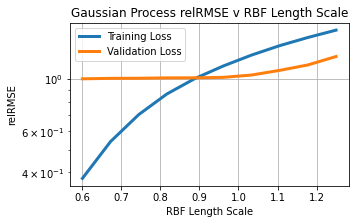

In [14]:
plt.figure(figsize = (5,3))
plt.plot(length_scale_sweep,train_loss,label = 'Training Loss',linewidth = 3)
plt.plot(length_scale_sweep,val_loss,label = 'Validation Loss',linewidth = 3)
#plt.xscale('log')
plt.yscale('log')

plt.grid()
plt.title('Gaussian Process relRMSE v RBF Length Scale')
plt.xlabel('RBF Length Scale')
plt.ylabel('relRMSE')

plt.legend()
best_val = length_scale_sweep[val_loss == min(val_loss)]
print(f'Best Val: {min(val_loss)}, at length scale: {best_val}')
#figSaver.save(filename = 'RBF_Length_scale_error')
print(val_loss)
print(train_loss)
print(length_scale_sweep)

In [5]:
ConstVals = np.linspace(0.01,20,100)

train_loss = []
val_loss = []

for ConstVal in ConstVals:
    kernel = ConstantKernel(ConstVal, constant_value_bounds="fixed") * RBF(2, length_scale_bounds="fixed")

    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))

plt.figure()
plt.plot(ConstVals,train_loss,label = 'Training Loss')
plt.plot(ConstVals,val_loss,label = 'Validation Loss')
plt.xlabel('ConstantKernel Length Scale')
ConstVals[val_loss == min(val_loss)]

KeyboardInterrupt: 

In [ ]:
kernel = ConstantKernel(1, constant_value_bounds="fixed") * RBF(0.6 ,length_scale_bounds="fixed")

std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

print(score(std_gp,train_params,train_fields))
print(score(std_gp,val_params,val_fields))

0.37750421259525807
1.002342679853638


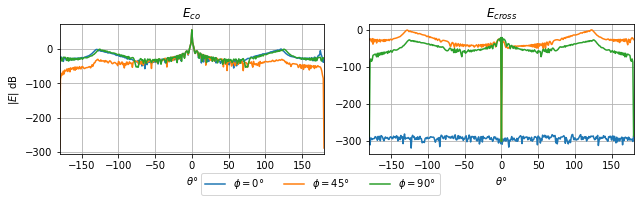

In [ ]:
from ssapp.visualization.data_visualisation import plot_dataset_field_example
plot_dataset_field_example(val_dataset,10)

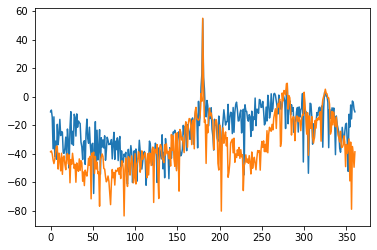

In [ ]:
mag_co = lambda x,i: 20*np.log10(np.sqrt(x[i,:,0,0]**2 + x[i,:,0,0]**2))

pred = std_gp.predict(val_params).reshape(-1,361,3,4)
idx =70
plt.figure()
plt.plot(mag_co(pred,idx),label = 'Training')
plt.plot(mag_co(val_fields,idx),label = 'Validation')